In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


In [2]:
def heatmap(sim_df, kg_df, genes):
    data_upper_df = sim_df.loc[genes, genes]
    data_lower_df = kg_df.loc[genes, genes]
    identity_matrix_df = pd.DataFrame(
        np.identity(len(genes)), index=genes, columns=genes
    )

    n_row = len(genes)
    n_col = len(genes)
    fig_width = n_row  + 1
    fig_height = n_col + 1

    # Create the clustermap
    g = sns.clustermap(
        data_upper_df,
        cmap="RdBu",
        row_cluster=True,
        col_cluster=True,
        vmin=0,
        vmax=1,
        figsize=(fig_width, fig_height),
        dendrogram_ratio=(0.1, 0.1),
    )
    g.cax.set_visible(False)

    # Mask the lower triangle
    mask = np.tril(np.ones_like(data_upper_df, dtype=bool))

    # Clustered genes order
    clustered_genes = [genes[i] for i in g.dendrogram_col.reordered_ind]

    # Apply the mask to the clustered heatmap
    sns.heatmap(
        data_upper_df.loc[clustered_genes, clustered_genes],
        mask=mask,
        cmap="RdBu",
        cbar=False,
        ax=g.ax_heatmap,
        annot=True,
        vmin=0,
        vmax=1,
    )

    # Overlay the second heatmap on the lower triangle
    sns.heatmap(
        data_lower_df.loc[clustered_genes, clustered_genes],
        mask=~mask,
        cmap="Greys",
        cbar=False,
        ax=g.ax_heatmap,
        annot=True,
        vmin=0,
        vmax=1,
    )

    # Mask the diagonal
    mask_diagonal = np.eye(data_upper_df.shape[0], dtype=bool)
    sns.heatmap(
        identity_matrix_df.loc[clustered_genes, clustered_genes],
        mask=~mask_diagonal,
        cmap="Greys_r",
        cbar=False,
        ax=g.ax_heatmap,
        annot=True,
    )

    return plt

In [3]:
orf_genesets = [
    ["SLC39A1", "ZBTB16"],
    ["SARS2", "ECH1", "DGUOK", "MRPS2", "LDHAL6B", "UQCRFS1"],
    ["MYT1", "LZTS2", "CHRM4", "GPR176", "TSC22D1"],
    ["SPDL1", "PAFAH1B1", "NDEL1", "NDE1", "HOOK2", "HOOK1"],
    ["MYT1", "INSYN1", "RNF41"],
    [
        "ZFP36L1",
        "PIK3R3",
        "NRBP1",
        "INSYN1",
        "HOXC8",
        "RAB40C",
        "RAB40B",
    ],
    [
        "YAP1",
        "WWTR1",
        "VGLL4",
        "PRKCE",
        "STK3",
        "CEP72",
        "IL20RB",
        "MTMR9",
    ],
]

crispr_genesets = [
    ["SLC39A1", "ZBTB16"],
    ["FOXO3", "TGFB1"],
    ["SARS2", "ECH1", "PVR", "LAIR1", "SLC1A5", "UQCRFS1"],
    ["MYT1", "CHRM4", "GPR176", "TSC22D1"],
    ["PIK3R3", "ZFP36L1", "HOXC8", "NRBP1", "RAB40B"],
]

In [4]:
orf_similarity_percentile_df = pd.read_parquet("cos_sim/cosine_similarities_percentile_genes_orf.parquet")

crispr_similarity_percentile_df = pd.read_parquet("cos_sim/cosine_similarities_percentile_genes_crispr.parquet")

In [5]:
knowledge_graph_orf = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_orf = pd.concat(
    [
        knowledge_graph_orf,
        knowledge_graph_orf.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph_orf = (
    knowledge_graph_orf.assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .query("gene_1 != gene_2")
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

knowledge_graph_orf = knowledge_graph_orf.pivot_table(
    index="gene_1", columns="gene_2", values="gene_kg"
)

knowledge_graph_crispr = pd.read_csv(
    "~/Downloads/crispr_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_crispr = pd.concat(
    [
        knowledge_graph_crispr,
        knowledge_graph_crispr.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph_crispr = (
    knowledge_graph_crispr.assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .query("gene_1 != gene_2")
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

knowledge_graph_crispr = knowledge_graph_crispr.pivot_table(
    index="gene_1", columns="gene_2", values="gene_kg"
)

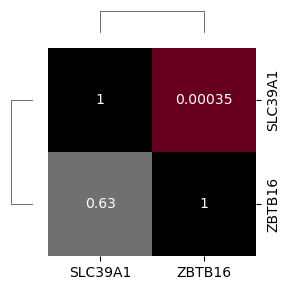

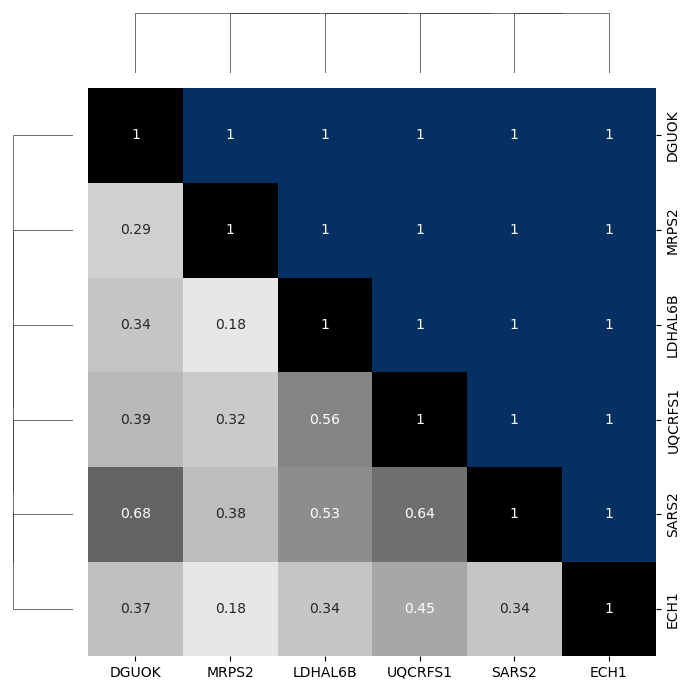

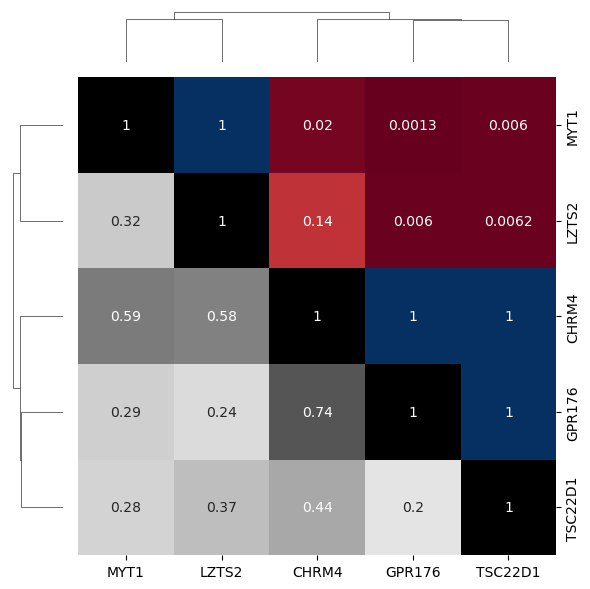

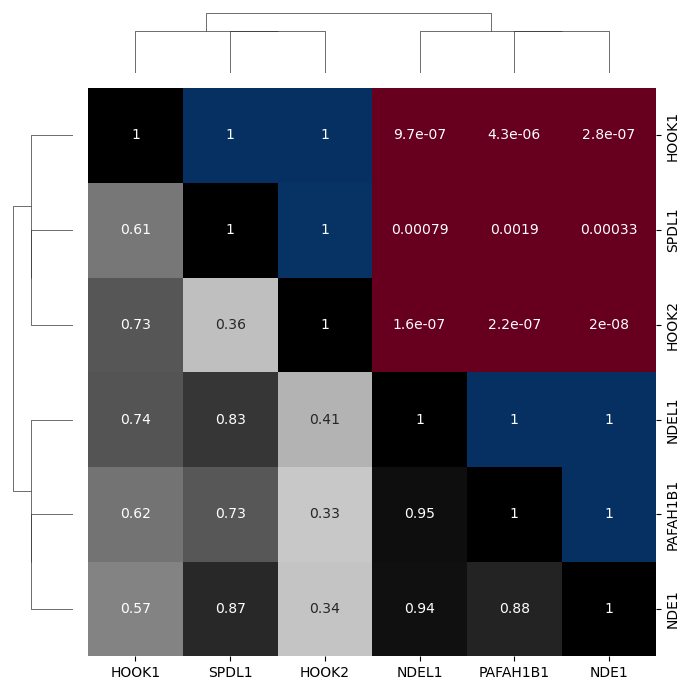

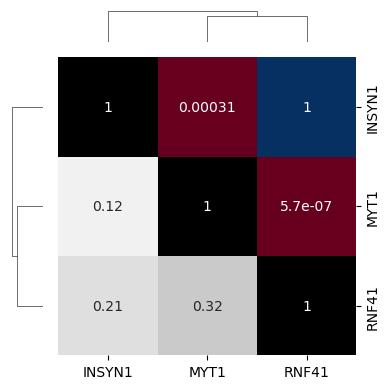

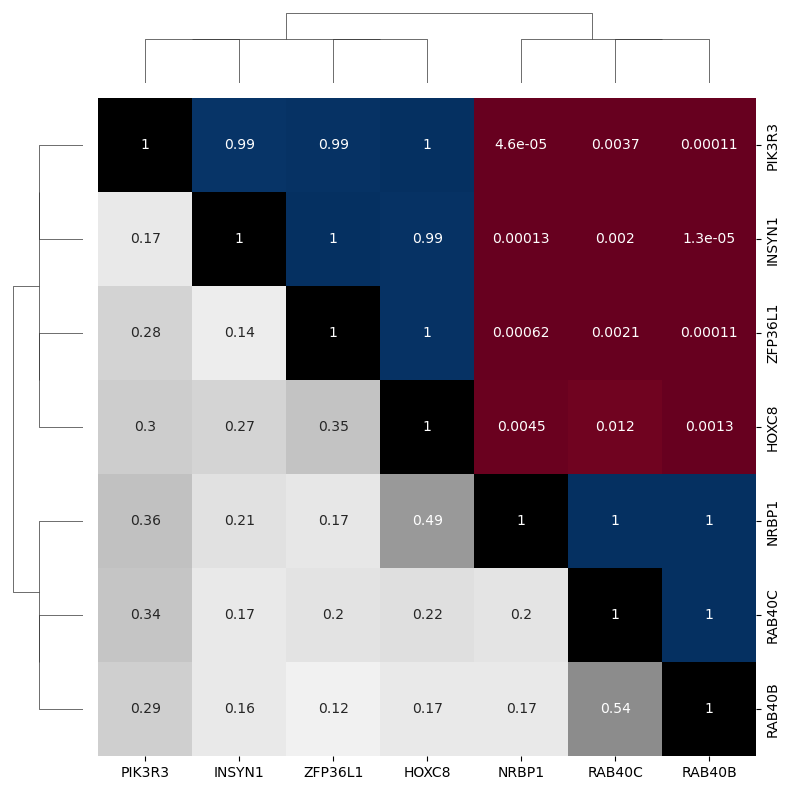

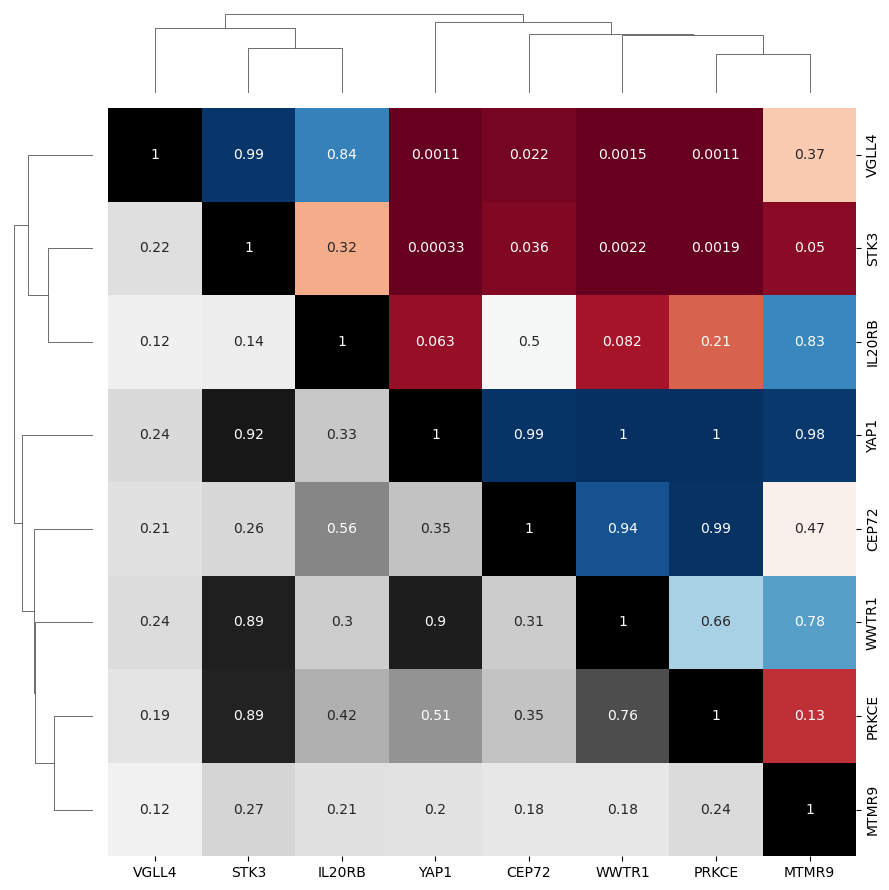

In [6]:
for geneset in orf_genesets:
    figure = heatmap(
    orf_similarity_percentile_df.loc[geneset, geneset],
    knowledge_graph_orf.loc[geneset, geneset],
    geneset,
)
    figure.tight_layout()
    figure.savefig(f"figures/heatmap-orf-{'-'.join(geneset)}.png", dpi=300)
    figure.savefig(f"figures/heatmap-orf-{'-'.join(geneset)}.svg", dpi=300)

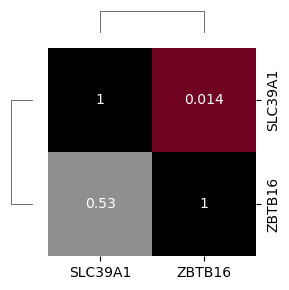

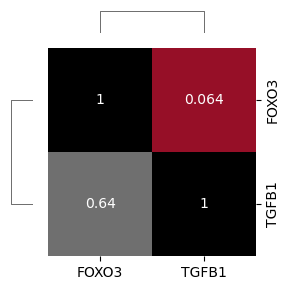

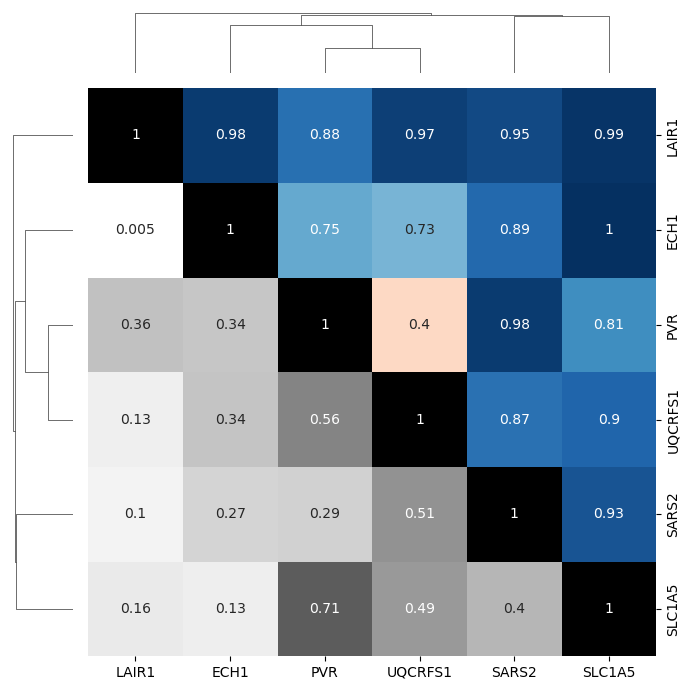

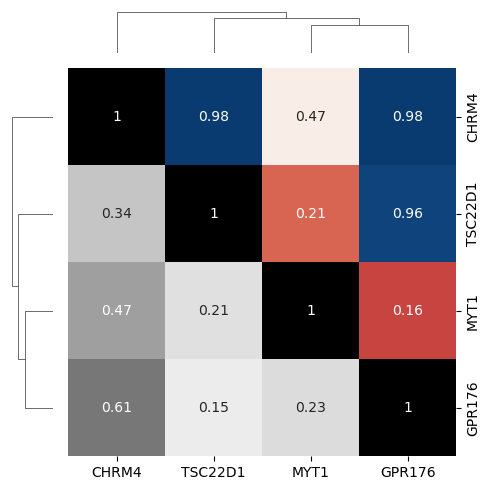

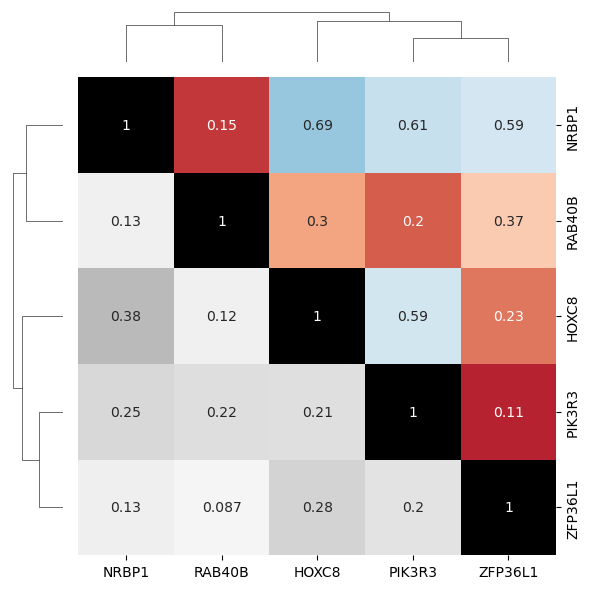

In [7]:
for geneset in crispr_genesets:
    figure = heatmap(
    crispr_similarity_percentile_df.loc[geneset, geneset],
    knowledge_graph_crispr.loc[geneset, geneset],
    geneset,
)
    figure.tight_layout()
    figure.savefig(f"figures/heatmap-crispr-{'-'.join(geneset)}.png", dpi=300)
    figure.savefig(f"figures/heatmap-crispr-{'-'.join(geneset)}.svg", dpi=300)

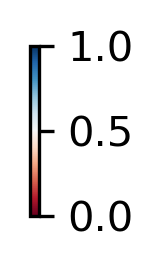

In [8]:
figsize = (1, 1)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
norm = Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation="vertical")
ax.remove()
plt.tight_layout()
plt.savefig("figures/rdbu-colorbar.png", dpi=300)
plt.savefig("figures/rdbu-colorbar.svg", dpi=300)

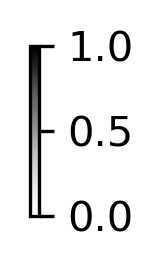

In [9]:
figsize = (1, 1)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
norm = Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation="vertical")
ax.remove()
plt.tight_layout()
plt.savefig("figures/greys-colorbar.png", dpi=300)
plt.savefig("figures/greys-colorbar.svg", dpi=300)

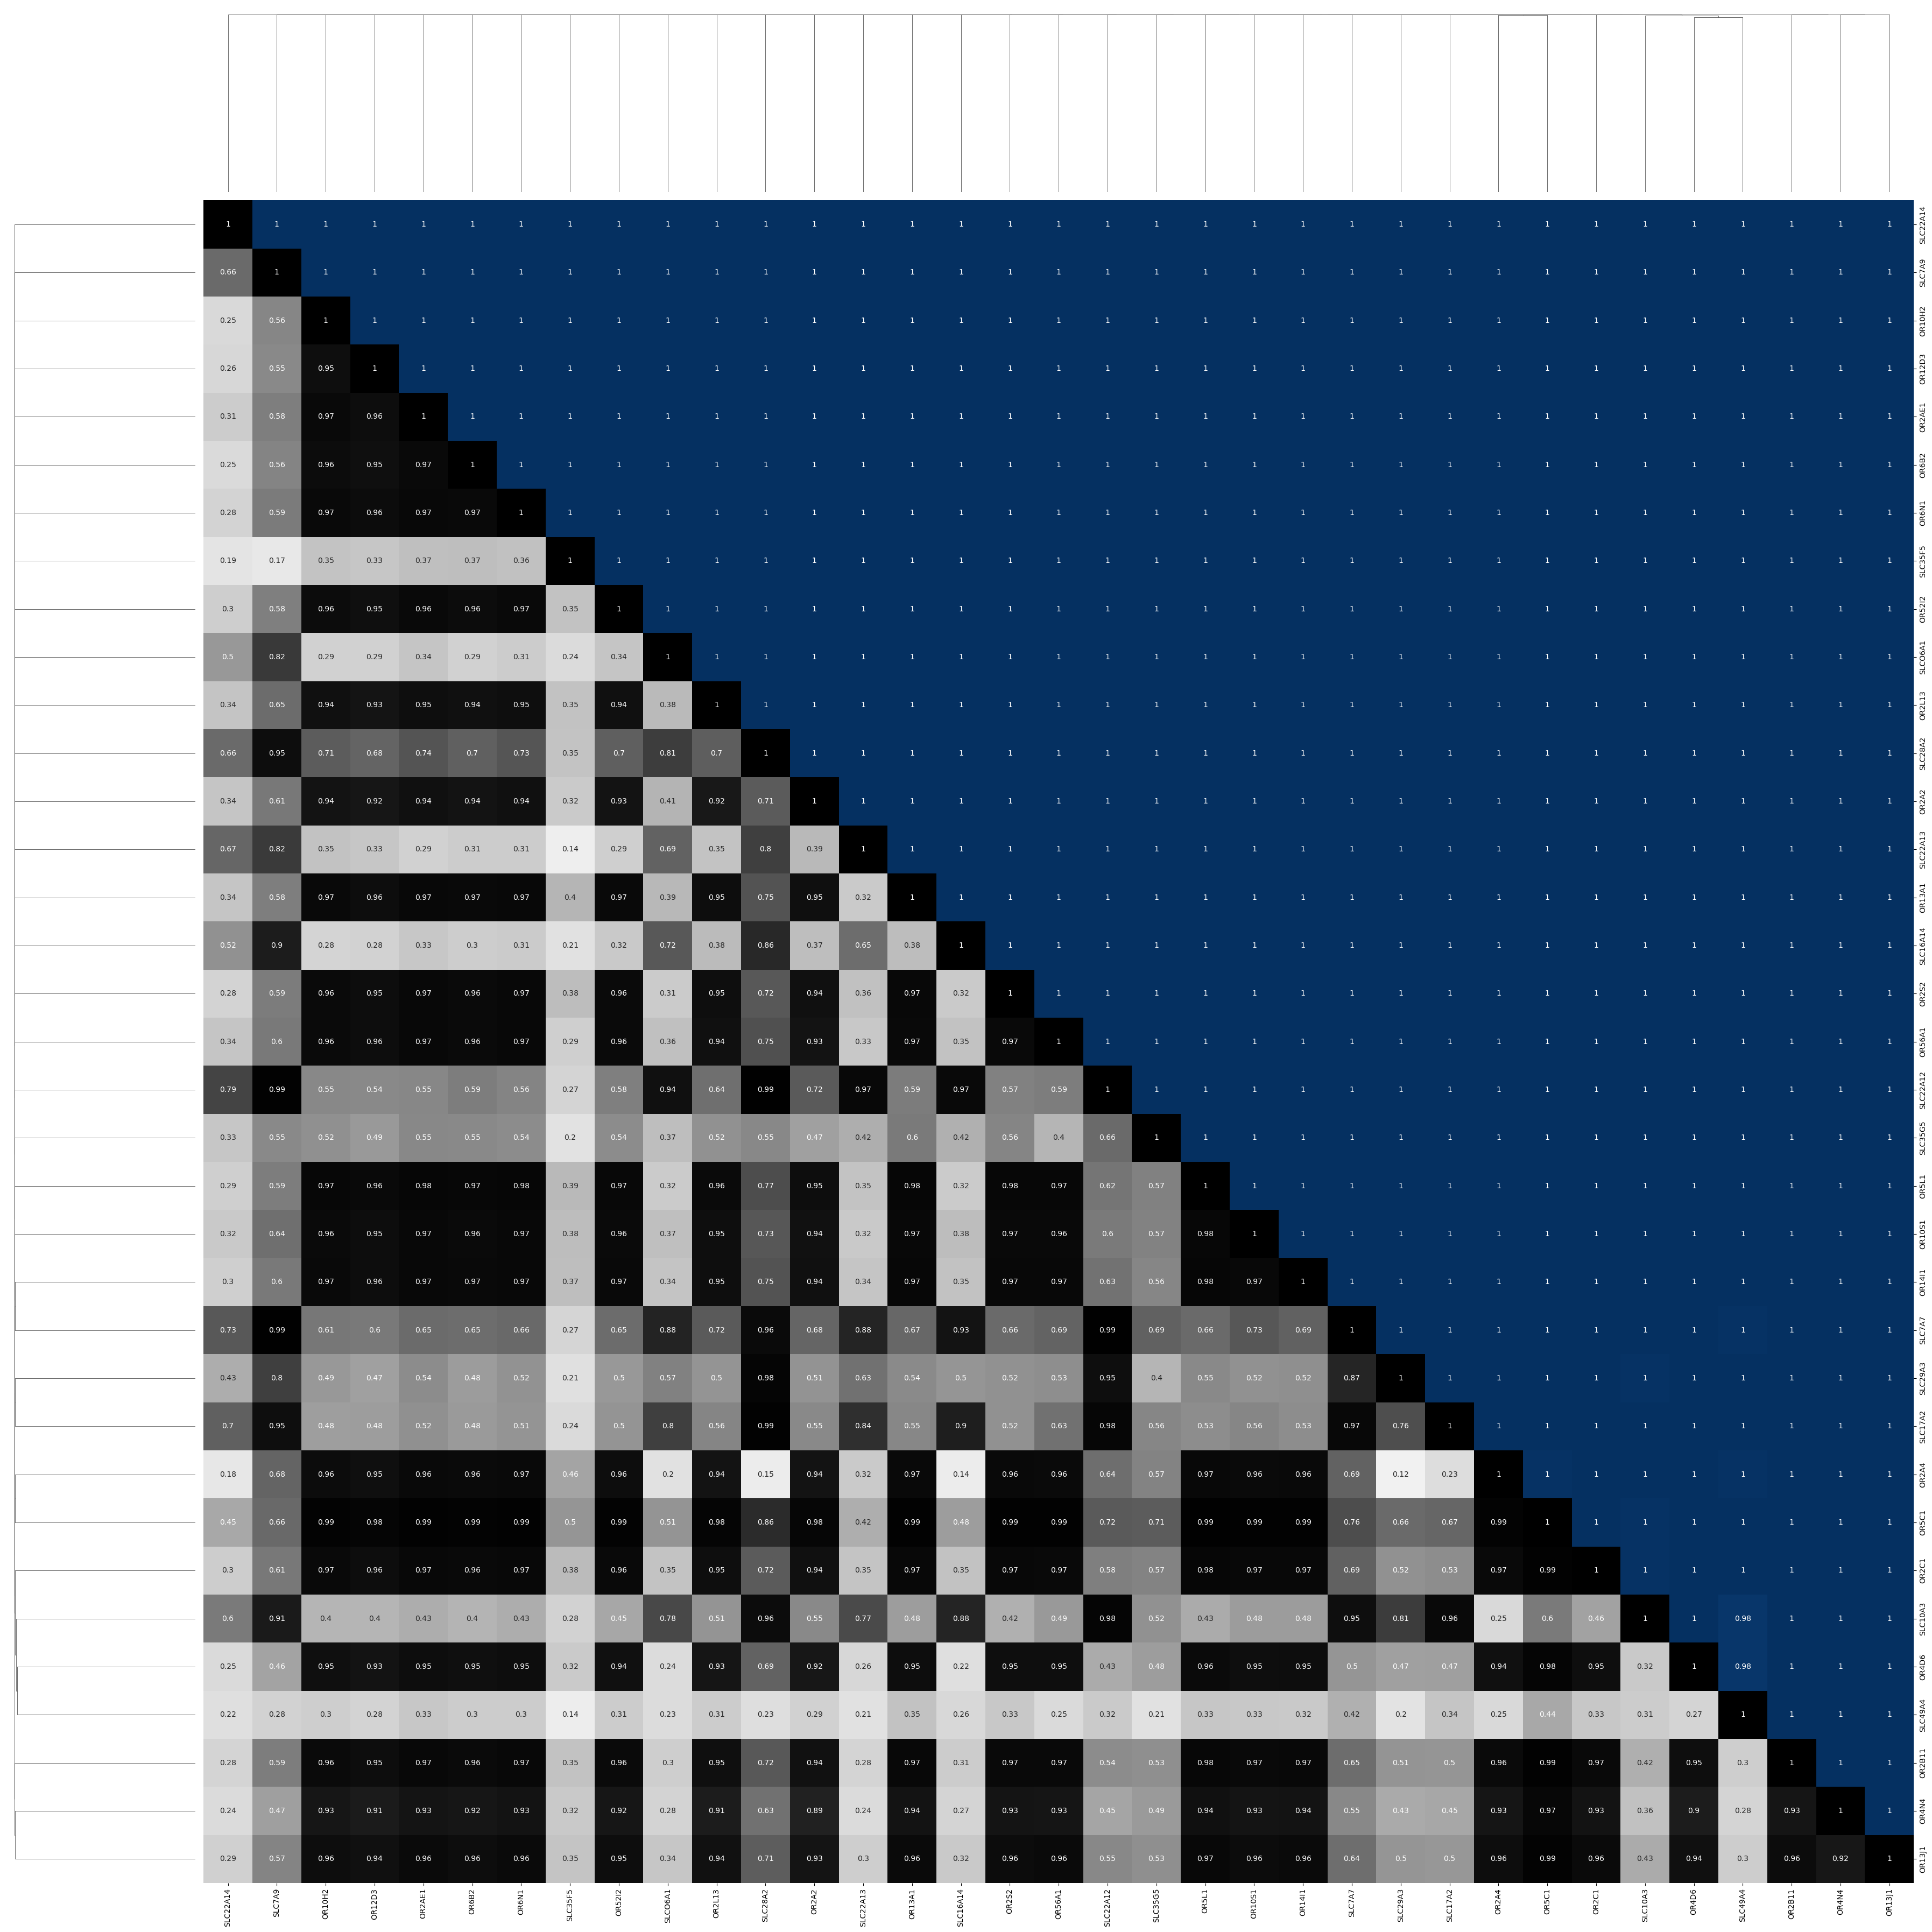

In [10]:
slc_or_genes = []
with open("output/SLC-OR_genes.txt") as f:
    for line in f:
        slc_or_genes.append(line.strip())

slc_or_genes.remove('OR7E2P')
slc_or_genes.remove('SLC35E2A')

figure = heatmap(
    orf_similarity_percentile_df.loc[slc_or_genes, slc_or_genes],
    knowledge_graph_orf.loc[slc_or_genes, slc_or_genes],
    slc_or_genes,
)
figure.tight_layout()
figure.savefig("figures/heatmap-orf-slc-or.png", dpi=300)
figure.savefig("figures/heatmap-orf-slc-or.svg", dpi=300)